# **Preparation**

- In order to train the Yolo v3 model, we will need to compile `darknet` which is an open source neural network framework written in C and CUDA. 
- Once the `darknet` is compiled, we will download the exported data set from HyperLabel


**Note**: Before starting to work, change the runtime to use the GPU.

If you don't have any dataset or pretrained model (weight) for that dataset, you can use our demo data set and trained weight.

Copy the following files to your Google drive (create a new folder called `ml` in your Google drive and put the files in there)

- [Dataset](https://drive.google.com/file/d/1wxHNFR2xXx6wJMJR2ey2NP_rWFJNs8-I/view?usp=sharing)
- [Pre trained weight](https://drive.google.com/file/d/1-5iEJhBgwRGBZ_ZBfO6Juo2tF6lGa4b6/view?usp=sharing)


### Clone darknet

In [1]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 12354, done.
remote: Total 12354 (delta 0), reused 0 (delta 0), pack-reused 12354
Receiving objects: 100% (12354/12354), 11.44 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (8392/8392), done.


### Compile darknet

In [2]:
%cd darknet
!sed -i 's/GPU=0/GPU=1/g' Makefile
!cat Makefile
!make

/content/darknet
GPU=1
CUDNN=0
CUDNN_HALF=0
OPENCV=0
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	  -gencode arch=compute_61,code=[sm_61,compute_61]

OS := $(shell uname)

# Tesla V100
# ARCH= -gencode arch=compute_70,code=[sm_70,compute_70]

# GeForce RTX 2080 Ti, RTX 2080, RTX 2070, Quadro RTX 8000, Quadro RTX 6000, Quadro RTX 5000, Tesla T4, XNOR Tensor Cores
# ARCH= -gencode arch=compute_75,code=[sm_75,compute_75]

# Jetson XAVIER
# ARCH= -gencode arch=compute_72,code=[sm_72,compute_72]

# GTX 1080, GTX 1070, GTX 1060, GTX 1050, GTX 1030

### Download the data set exported from HyperLabel


In [4]:
import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')
  
DOWNLOAD_LOCATION = '/content/darknet/data/'
DRIVE_DATASET_FILE = '/content/gdrive/My Drive/ml/card-dataset.zip' #adjust path/name of dataset which is in your G-drive

shutil.copy(DRIVE_DATASET_FILE, DOWNLOAD_LOCATION)

print('Successfully downloaded the dataset')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Successfully downloaded the dataset


### Unzip the dataset

In [5]:
!unzip data/card-dataset.zip -d data/ # adjust the dataset filename which you have downloaded from Google drive

Output hidden; open in https://colab.research.google.com to view.

##Training the model

- Download the initial weight
- Train the model

### Download initial pre-trained weights for the convolutional layers (If you have already trained and saved the weights to your Google drive, you can skip this)

In [7]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-01-17 15:10:33--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  88.4MB/s    in 1.8s    

2020-01-17 15:10:35 (88.4 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



### Set Yolo configurations

We need to set configurations for Yolo in order to properly train. There are few settings which we need to change in the default yolov3.cfg file.

- batch
- subdivisions (if you get memory out error, increase this 16, 32 or 64)
- max_batches (it should be classes*2000)
- steps (it should be 80%, 90% of max_batches)
- classes (the number of classes which you are going to train)
- filters (the value for filters can be calculated using (classes + 5)x3 )

Change the values below as per your requirement

In [9]:
!sed -i 's/batch=1/batch=64/g' cfg/yolov3.cfg
!sed -i 's/subdivisions=1/subdivisions=32/g' cfg/yolov3.cfg
!sed -i 's/max_batches = 500200/max_batches = 104000/g' cfg/yolov3.cfg
!sed -i 's/steps=400000,450000/steps=83200,93600/g' cfg/yolov3.cfg
!sed -i 's/classes=80/classes=52/g' cfg/yolov3.cfg
!sed -i 's/filters=255/filters=171/g' cfg/yolov3.cfg
!cat cfg/yolov3.cfg

[net]
# Testing
batch=64
subdivisions=32
# Training
# batch=64
# subdivisions=326
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 104000
policy=steps
steps=83200,93600
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolution

**Now we are moving forward with the training part. If you have already trained the model, you can fetch them from Google drive and skip the training part.**

In [0]:
# Only run this cell, if you have already trained the model and have weights and backup files in your Google drive
# (Optional) Download the pretrained weight from Google drive

import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')
  
BACKUP_FOLDER = '/content/darknet/backup'
DRIVE_YOLO_BACKUP = '/content/gdrive/My Drive/ml/yolov3_last.weights'

shutil.copy(DRIVE_YOLO_BACKUP, BACKUP_FOLDER)

print('Successfully fetched the pretrained files for Yolo from Google drive')

Successfully fetched the pretrained files for Yolo from Google drive


### Start the training

It will take a long time to complete, so sit back and relax

Note: If during training you see nan values for avg (loss) field - then training goes wrong, but if nan is in some other lines - then training goes well.

- file yolo-obj_last.weights will be saved to the darknet/backup for each 100 iterations
- file yolo-obj_xxxx.weights will be saved to the darknet/backup for each 1000 iterations
- After each 100 iterations if you want, you can stop and later start training from this point. For example, after 2000 iterations you can stop training, and later just start training using: darknet detector train data/obj.data yolov3.cfg backup/yolo-obj_2000.weights

In [10]:
# use the line below to train a fresh model
!./darknet detector train data/obj.data cfg/yolov3.cfg darknet53.conv.74

# use the line below to retrain your previous saved weight
#!./darknet detector train data/obj.data cfg/yolov3.cfg backup/yolov3_last.weights

 CUDA-version: 10000 (10010)
, GPU count: 1  
 OpenCV isn't used 
yolov3
net.optimized_memory = 0 
batch = 2, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 

In [0]:
# Once you have trained your model, you can save them to your Google drive. So that next time, you don't need to retrain
# This step is optional, you can skip it if you want
import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')
  
YOLO_BACKUP = '/content/darknet/backup/yolov3_last.weights' #adjust the backup file name or keep it default
DRIVE_DIR = '/content/gdrive/My Drive/ml/' #adjust path in your Google drive, or keep it default

shutil.copy(YOLO_BACKUP, DRIVE_DIR)

print('Saved training data to drive at: ' + DRIVE_DIR)

## Running predictions

In [0]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

 CUDA-version: 10000 (10010)
, GPU count: 1  
 OpenCV isn't used 
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
  10 conv   

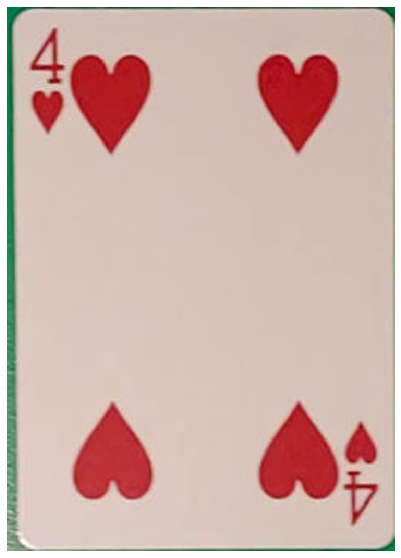

In [0]:
!./darknet detector test data/obj.data cfg/yolov3.cfg backup/yolov3_last.weights /content/427234163.png
# Show the result using the helper imgShow()
imShow('predictions.jpg')

### Display result

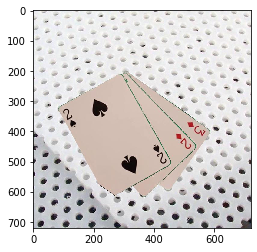

In [0]:
def display_image(file_path = '/content/darknet/predictions.jpg'):
    import cv2
    import matplotlib.pyplot as plt
    import os.path

    if os.path.exists(file_path):
      img = cv2.imread(file_path)
      show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
      plt.imshow(show_img)
    else:
      print('failed to open file')
    
display_image()